### <center>IMPORTS</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [2]:
def model_evaluation(y_test, yhat):
    
    cm = confusion_matrix(y_test,yhat)
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.3%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels, fmt ='')
    
    print(classification_report(y_test,yhat))

In [3]:
def score_evaluation(classifier, X_train, Y_train, Y_test, Yhat):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    cr_v_score = cross_val_score(classifier, X_train, Y_train, cv=cv, scoring='roc_auc')
    r_a_score  = roc_auc_score(Y_test, Yhat)
    print("Cross Validation Score : ",'{0:.2%}'.format(cr_v_score.mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(r_a_score))

### <center>PREPARE DATA</center>

In [4]:
df = pd.read_csv('features.csv')
df.head()

,Age,Gender,Balance,NumOfProducts,Geography,IsActiveMember,Exited
0,42,1,0.00,1,France,1,1
1,41,1,83807.86,1,Spain,1,0
2,42,1,159660.80,3,France,0,1
3,39,1,0.00,2,France,0,0
4,43,1,125510.82,1,Spain,1,0


In [5]:
X = df.drop(columns=['Exited', 'Geography'], axis=1)
X.head()

,Age,Gender,Balance,NumOfProducts,IsActiveMember
0,42,1,0.00,1,1
1,41,1,83807.86,1,1
2,42,1,159660.80,3,0
3,39,1,0.00,2,0
4,43,1,125510.82,1,1


In [6]:
Y = df['Exited'].to_numpy()
Y[0:5]

array([1, 0, 1, 0, 0], dtype=int64)

### <center>TRANSFORM DATA</center>

In [7]:
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)
X[0:5]

array([[ 0.29351742,  1.09598752, -1.22584767, -0.91158349,  0.97024255],
       [ 0.19816383,  1.09598752,  0.11735002, -0.91158349,  0.97024255],
       [ 0.29351742,  1.09598752,  1.33305335,  2.52705662, -1.03067011],
       [ 0.00745665,  1.09598752, -1.22584767,  0.80773656, -1.03067011],
       [ 0.38887101,  1.09598752,  0.7857279 , -0.91158349,  0.97024255]])

### <center>SPLIT DATA</center>

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

In [9]:
for data in [X_train, X_test, Y_train, Y_test]:
    print(data.shape)

(8000, 5)
(2000, 5)
(8000,)
(2000,)


### <center>MODEL 1: LOGISTIC REGRESSION</center>

In [10]:
parameters={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [11]:
lr = LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv=10)

In [12]:
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [13]:
print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hyperparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8055


In [14]:
logreg_cv.score(X_test, Y_test)

0.7995

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1588
           1       0.57      0.11      0.18       412

    accuracy                           0.80      2000
   macro avg       0.69      0.54      0.53      2000
weighted avg       0.76      0.80      0.74      2000



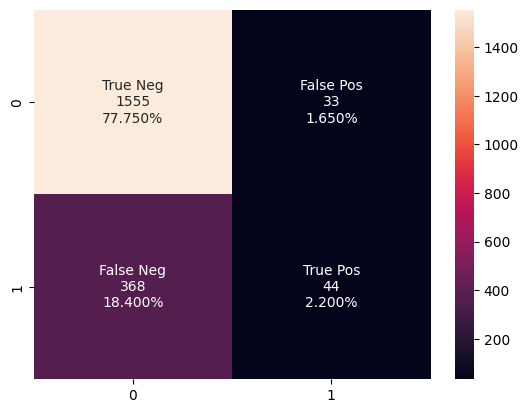

In [15]:
Yhat1 = logreg_cv.predict(X_test)
model_evaluation(Y_test, Yhat1)

#### ANALYSIS:
* The model appears to predict true negatives (whether a user will be retained or not) but fails to predict churn effectively. 
* What is also concerning is the significant amount of false negatives; Implying the model is predicting actually churned users as retained users

#### SOLUTION:
* Apply SMOTE oversampling technique to counter class imbalance

In [16]:
over = SMOTE(sampling_strategy = 1)

X, Y = over.fit_resample(X, Y)
Counter(Y)

Counter({1: 7963, 0: 7963})

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

In [18]:
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [19]:
print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hyperparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.6959968602825746


In [20]:
logreg_cv.score(X_test, Y_test)

0.6914626490897677

              precision    recall  f1-score   support

           0       0.68      0.71      0.69      1562
           1       0.71      0.67      0.69      1624

    accuracy                           0.69      3186
   macro avg       0.69      0.69      0.69      3186
weighted avg       0.69      0.69      0.69      3186



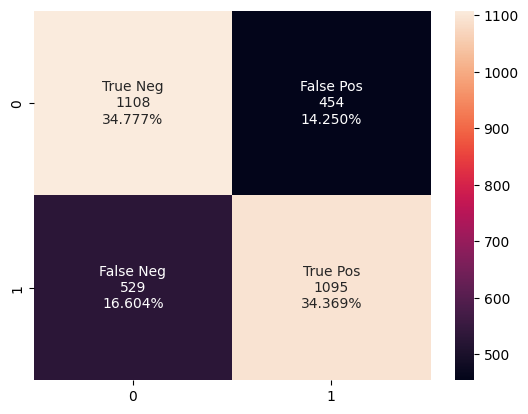

In [21]:
Yhat1 = logreg_cv.predict(X_test)
model_evaluation(Y_test, Yhat1)

In [22]:
score_evaluation(lr, X_train, Y_train, Y_test, Yhat1)

Cross Validation Score :  76.13%
ROC_AUC Score :  69.18%


#### ANALYSIS: 
* SMOTE Application has resulted in greater true-positive prediction (churn prediction), but has resulted in greater false positives and fewer true negatives
---

### <center>MODEL 2: DECISION TREE</center>

In [23]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['sqrt', 'log2'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [24]:
tree_cv = GridSearchCV(tree, parameters, cv=10)

In [25]:
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [26]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 18, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.8149136577708006


In [27]:
tree_cv.score(X_test, Y_test)

0.8097928436911488

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1562
           1       0.84      0.78      0.81      1624

    accuracy                           0.81      3186
   macro avg       0.81      0.81      0.81      3186
weighted avg       0.81      0.81      0.81      3186



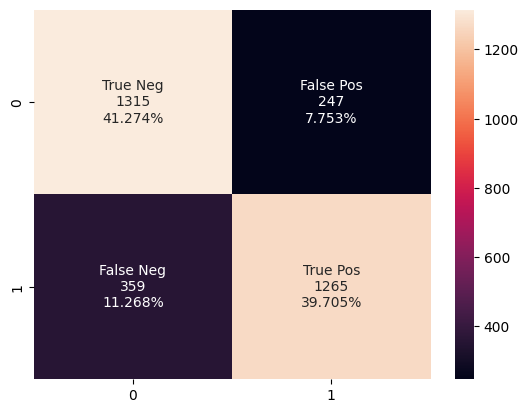

In [28]:
Yhat2 = tree_cv.predict(X_test)
model_evaluation(Y_test, Yhat2)

In [29]:
score_evaluation(tree, X_train, Y_train, Y_test, Yhat2)

Cross Validation Score :  82.50%
ROC_AUC Score :  81.04%


#### ANALYSIS:
* Number of False Positives and False Negatives has decreased overall with Decision Tree Model
---

### <center>MODEL 3: K-NEAREST-NEIGHBOUR</center>

In [30]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

In [31]:
KNN = KNeighborsClassifier()

In [32]:
knn_cv = GridSearchCV(KNN, parameters, cv=10)

In [33]:
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [34]:
print("tuned hyperparameters (best parameters): ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hyperparameters (best parameters):  {'algorithm': 'brute', 'n_neighbors': 1, 'p': 1}
accuracy : 0.8142857142857144


In [35]:
knn_cv.score(X_test, Y_test)

0.8170119271814187

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1562
           1       0.83      0.81      0.82      1624

    accuracy                           0.82      3186
   macro avg       0.82      0.82      0.82      3186
weighted avg       0.82      0.82      0.82      3186



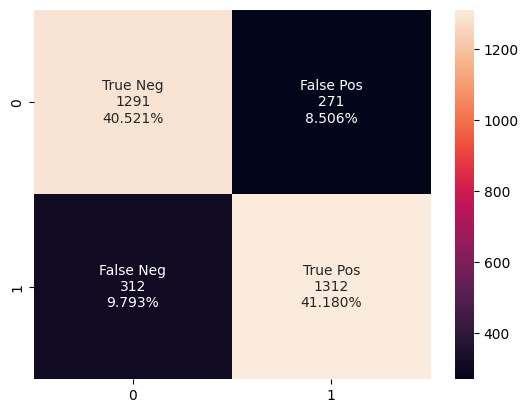

In [36]:
Yhat3 = knn_cv.predict(X_test)
model_evaluation(Y_test, Yhat3)

In [37]:
score_evaluation(KNN, X_train, Y_train, Y_test, Yhat3)

Cross Validation Score :  87.67%
ROC_AUC Score :  81.72%


#### ANALYSIS:
1. KNN-Model has an even distribution between the accurate predictions, with 10.013% false negatives and 7.972% false positives
---

### <center>MODEL COMPARISON</center>

In [38]:
predictors = {'KNN': knn_cv, 'Logistic': logreg_cv, 'DecisionTree': tree_cv}
best_predictor_name = ""
best_result = 0

for predictor_name, predictor_model in predictors.items():
    score = predictor_model.score(X_test, Y_test)
    if score > best_result:
        best_result = score
        best_predictor_name = predictor_name

print(f"Best predictor: {best_predictor_name}\nBest score    : {best_result*100:.5f}%")

Best predictor: KNN
Best score    : 81.70119%


---

## <center>INFERENCES</center>

1. **QUALITY OF DATA**: There is data bias present in the form of class imbalance. This is seen as the number of churned user data is far lesser than that of retained user data. The useful features were "Age", "Gender", "Balance", "NumOfProducts" and "IsActiveMember"
2. **MODEL SELECTION**: The models selected were classification algorithms. This was chosen as the dependent variable "Exited" (referring to the churn status of a user where 0=Retained, 1=Churned) was a boolean(categorical) variable. For this purpose, *Logistic Regression*, *Decision Tree*, and *K-Nearest Neighbours* was used for predictive analysis.
3. **EFFECT OF SMOTE**: Synthetic Minority Oversampling Technique (SMOTE) is an oversampling technique where synthetic samples are generated for the minority class, here that being *Exited=0*. This algorithm is used to counter the overfitting problem is biased datasets.
4. **RESULT OF TESTS**:  
With SMOTE:  
  **K-NEAREST NEIGHBOURS** with an accuracy score of 81.70%  
Without SMOTE:  
  **DECISION TREE MODEL** with an accuracy score of 84.65%.